**Chapter 16 – Natural Language Processing with RNNs and Attention**

_This notebook contains all the sample code in chapter 16._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

https://teddylee777.github.io/tensorflow/dataset-batch-window

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
print(dataset)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
print(dataset)
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorShape([]))>
<FlatMapDataset shapes: (None,), types: tf.int32>
____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

셰익스피어의 작품을 학습한 Char-RNN으로 만들어진 샘플들

단어, 문법, 정확한 발음 등을 학습해 단순히 다음 문자를 예측하는 모델

In [8]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [9]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [10]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

토크나이저를 만든다.

character -> integer

1부터 출발하는 정수

토크나이저는 디폴트로 소문자로 바꾼다.

In [17]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [12]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [13]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [16]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters
print(max_id, dataset_size)

39 1115394


training set 90% validation set 그다음 5%, test set은 나머지 5%로 하면 안겹친다.

In [18]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
for X_batch in dataset.take(10):
    print(X_batch)

tf.Tensor(19, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(18, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


In [19]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)
for X_batch in dataset.take(2):
    print(X_batch)

<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


In [20]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))
for X_batch in dataset.take(2):
    print(X_batch)

tf.Tensor(
[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24
 17  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23
 10 15  3 13  0], shape=(101,), dtype=int64)
tf.Tensor(
[ 5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1  0
 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1  4
  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24 17
  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23 10
 15  3 13  0  4], shape=(101,), dtype=int64)


In [21]:
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
#dataset = dataset.batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
for X_batch, Y_batch in dataset.take(2):
    print('......', X_batch.shape, Y_batch.shape)

...... (32, 100) (32, 100)
...... (32, 100) (32, 100)


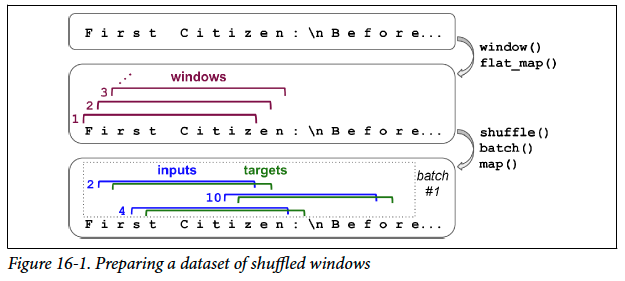

데이터는 전부 one-hot이다.

In [23]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [24]:
dataset = dataset.prefetch(1)

In [25]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

이전 100 문자들로부터 다음 문자를 예측하기 위해

128 units인 2 GRU layer

input과 hidden states에 20% dropout

timedistributed

39개의 출력이고 softmax probability로 변환 가능. 

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
31370/31370 [==============================] - 398s 12ms/step - loss: 2.0369
Epoch 2/10
31370/31370 [==============================] - 394s 13ms/step - loss: 1.8004
Epoch 3/10
31370/31370 [==============================] - 388s 12ms/step - loss: 1.7643
Epoch 4/10
31370/31370 [==============================] - 366s 12ms/step - loss: 1.7473
Epoch 5/10
31370/31370 [==============================] - 365s 12ms/step - loss: 1.7375
Epoch 6/10
31370/31370 [==============================] - 362s 12ms/step - loss: 1.7305
Epoch 7/10
31370/31370 [==============================] - 365s 12ms/step - loss: 1.7252
Epoch 8/10
31370/31370 [==============================] - 362s 12ms/step - loss: 1.7210
Epoch 9/10
31370/31370 [==============================] - 363s 12ms/step - loss: 1.7174
Epoch 10/10
31370/31370 [==============================] - 365s 12ms/step - loss: 1.7145


## Using the Model to Generate Text

how are yo 다음에 u를 예측했다.

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(["How are yo"])
print(X_new)
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

tf.Tensor(
[[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'u'

## Generating Fake Shakespearean Text

Char-RNN model을 사용해 새로운 텍스트를 만들기 위해서는 약간의 텍스트를 입력해야한다.

이렇게 새로운 문장을 계속 만들다보면 실제로는 계속 같은 단어가 반복된다.

그래서 tf.random.categorical을 사용해서 주어진 logits을 기반으로 class indice를 생성한다.

그냥 확률이 max인 라벨을 클래스로 사용하는 것이 아니라 다시 생성하여
더 다양한 문장을 만들 수 있다.

생성된 텍스트의 다양성을 더 많이 제어하려면 temperature라고 불리는 숫자로 로짓을 나눔. 온도는 원하는 값으로 설정할 수 있는데 0에 가까울수록 높은 확률을 가진 글자를 선택.

In [ ]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the dead, sir, i will be so so met her with a stand


In [ ]:
print(complete_text("t", temperature=1))

toke the
done. then off no honring soentes?

horten


In [ ]:
print(complete_text("t", temperature=2))

tpeyiomevely
wrin?gmaz hicely'd getderinurs:
-faeem


## Stateful RNN

지금까지 써온 RNN은 stateless다. 매 iteration마다 hidden state가 0으로 시작하는
만약 batch training 한 후 final state를 다음 batch에서 초기값으로 쓸 수 있다면?
이러한 방법은 모델이 짧은 시퀀스에 대해 backpropa함에도 불구하고 long-term 패턴을 학습할 수 있다.

이게 바로 stateful RNN

첫번째로 기억해야하는 것은 데이터가 시퀀설하게 들어가야하고 overlap이 없어야 한다.

데이터셋을 만들 때 shift를 window_length만큼 해야한다. 셔플도 하면 안된다.

batch 단위로 학습 시킬 때 이제 문제가 되는데 그냥 batch를 1쓰면 된다.

In [ ]:
tf.random.set_seed(42)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

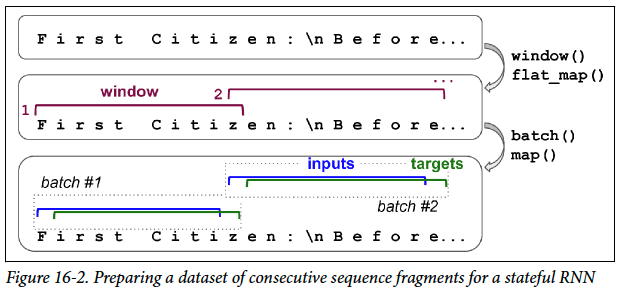

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, #recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

매 에포크마다 state를 reset 해줘야 한다.

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 6s 12ms/step - loss: 2.9053
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 2.2869
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 2.1371
Epoch 4/50
313/313 [==============================] - 4s 12ms/step - loss: 2.0538
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9968
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9582
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9287
Epoch 8/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9025
Epoch 9/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8834
Epoch 10/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8708
Epoch 11/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8576
Epoch 12/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8443
Epoch 13/50
3

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [ ]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [ ]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [ ]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [ ]:
tf.random.set_seed(42)

print(complete_text("t"))

thing idsumper your shint.
why, he has go too stone


# Sentiment Analysis

컴퓨터 비전에 MNIST가 있다면, 자연어 처리에는 IMDb가 있다.

25000 training set, 25000 test set으로 총 50000개의 영화 리뷰가 있다. 라벨로는 negative 0, positive 1이다.

In [ ]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [ ]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

케라스에 이미 numpy의 integer ndarray로 전처리 되어있다.

index는 frequency 기준으로 나열되어 있음.

0은 padding token, 1은 start-of-sequence token, 2는 unknown token

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBY7R9S/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBY7R9S/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBY7R9S/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [ ]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [ ]:
train_size, test_size

(25000, 25000)

In [ ]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



리뷰중에 앞에 300글자만 남겨둔다. 속도도 빨라지고 성능에도 큰 영향 없다.

불필요한 문자들도 없앤다.

스페이스 기준으로 나눈다.

<pad> token으로 패딩하여 길이를 모두 맞춘다.

In [ ]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [ ]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

vocabulary를 만들어야한다. 모든 데이터를 전체 검사하며 단어가 몇번 나왔는지 체크한다.

In [ ]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [ ]:
len(vocabulary)

53893

모든 단어를 사용할 필요는 없다. 자주 나온 10000만 사용하자.

In [ ]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [ ]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


룩업 테이블 만들고

In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

preprocessing하며 데이터셋을 만든다.

In [ ]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


임베딩하고 GRU 2개 지나고 dense layer 지나면 끝

임베딩 레이어의 입력은 [batch size, time steps], 출력은 [batch size, time steps, embedding size]

첫번째 GRU layer는 출력 시퀀스를 리턴하고, 두번째 GRU layer는 마지막 time step의 출력만 리턴한다.

마지막은 하나의 sigmoid로 결정된다. 0-1로 왜냐면 라벨이 0이 negative, 1이 positive

In [ ]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 31s 32ms/step - loss: 0.5957 - accuracy: 0.6606
Epoch 2/5
781/781 [==============================] - 25s 32ms/step - loss: 0.3701 - accuracy: 0.8398
Epoch 3/5
781/781 [==============================] - 24s 31ms/step - loss: 0.2081 - accuracy: 0.9237
Epoch 4/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1412 - accuracy: 0.9513
Epoch 5/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1072 - accuracy: 0.9602


모델은 padding token들을 무시하고 학습해야한다.

Embedding layer를 만들 때 mask_zero=True로 하면 무시된다.

Or using manual masking:

들어온 입력이 0이냐 아니냐 boolean tensor를 만들어서 간단하게 마스킹한다.

In [ ]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 31s 32ms/step - loss: 0.6094 - accuracy: 0.6406
Epoch 2/5
781/781 [==============================] - 25s 31ms/step - loss: 0.3715 - accuracy: 0.8423
Epoch 3/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1961 - accuracy: 0.9274
Epoch 4/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1238 - accuracy: 0.9552
Epoch 5/5
781/781 [==============================] - 25s 32ms/step - loss: 0.1059 - accuracy: 0.9598


## Reusing Pretrained Embeddings

TenforFlow Hub에 들어가면 미리 학습되어 있는 embedding layer가 많다.

쉽게 다운로드해서 쓸 수 있다.

In [26]:
tf.random.set_seed(42)

In [27]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [28]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [30]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5861 - accuracy: 0.6919
Epoch 2/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5181 - accuracy: 0.7445
Epoch 3/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5122 - accuracy: 0.7491
Epoch 4/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5084 - accuracy: 0.7492
Epoch 5/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5054 - accuracy: 0.7520


디폴트로는 학습이 안되는데 trainable=True로 바꿔서 학습시킬 수도 있다.

# Automatic Translation

**주의**: 이 섹션의 코드는 텐서플로 애드온 0.10.0에서 에러가 발생합니다. 0.9.1 버전을 설치하세요.

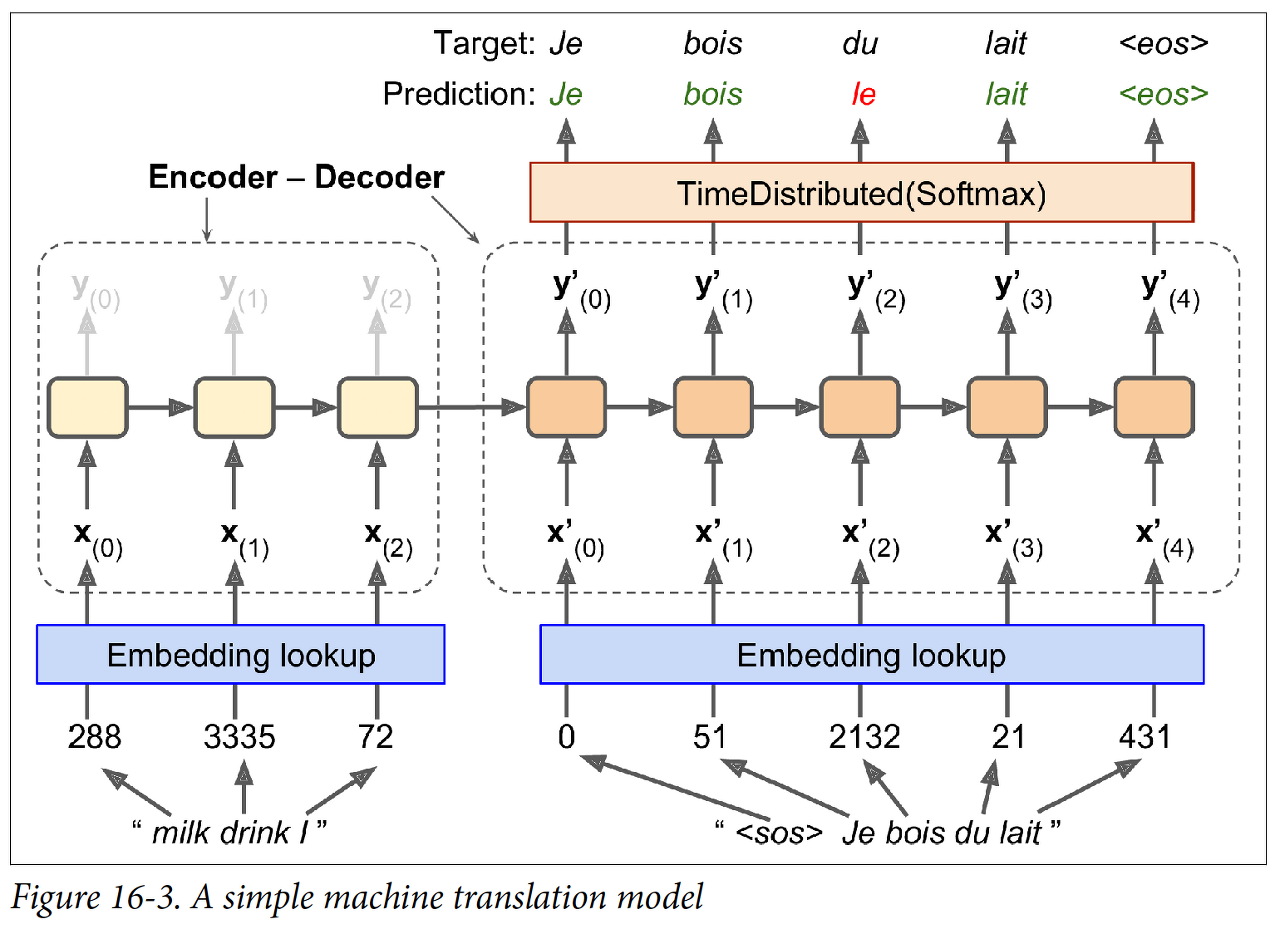

영어를 프랑스어로 번역하는 모델

인코더의 입력으로 영어가 들어가고 디코더의 출력으로 프랑스어가 나온다.

디코더의 입력으로 한칸씩 쉬프트된 프랑스어 번역이 사용된다. 이전 스텝의 출력이 현재 스텝의 입력으로 (실제 출력이 아닐지라도)

첫번째는 start-of-sentence token, 마지막에는 end-of-sentence token

영어가 입력으로 들어갈 때 문장의 순서와 반대로 들어간다. 번역에 필요한 디코더의 첫번째 요소가 영어에서는 가장 첫 단어일테니

단어별로 ID를 가지며 임베딩 레이어를 통과해 얻은 값들이 인코더 디코더의 입력으로 들어간다.

디코더의 출력은 각 단어의 점수를 출력하고 소프트맥스를 거쳐 확률로 바뀐다. 가장 큰 확률인 단어를 고르면 된다. 일반적인 classification task처럼

crossentropy loss를 사용할 수 있다.

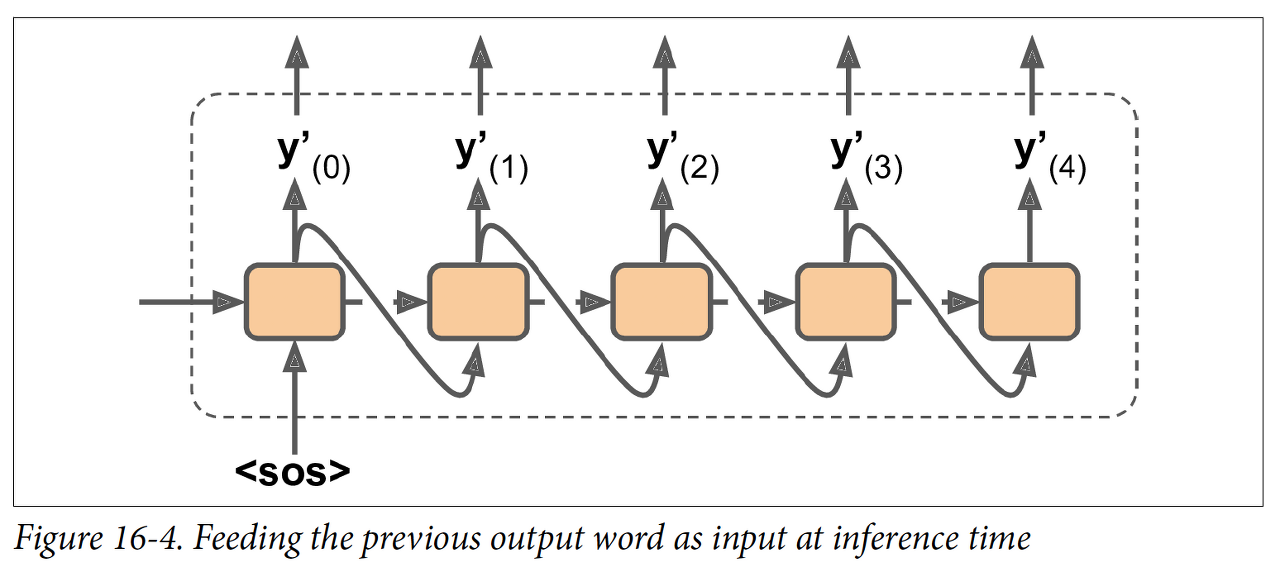

이와 같이 이전 스텝의 출력을 현재 스텝의 입력으로 사용한다.
인풋 시퀀스의 길이가 같다고 가정을 했다.

하지만 문장의 길이는 모두 다르다.

텐서는 고정된 shape을 사용해야해서 마스킹을 통해 문장의 길이가 다른 문제를 해결했다.

하지만 길이가 너무 다르다면, 감정 분석때 하던 것처럼 간단히 자를수도 없다. (번역문제이기 때문)

대신에 비슷한 길이들을 하나의 bucket에 담을 수 있다.

예를 들어 1-6 단어 문장 버킷, 7-12 단어 문장 버킷

버킷을 사용하는 이유는 학습속도 증가

EOS token 다음의 출력은 무시되어야 한다. loss에 더해지면 안된다. 마스킹 되어야 한다.

예를 들어 "Je bois du lait <eos> oui."에서 oui는 무시

만약 출력 단어의 수가 매우 많다면, 각각 모든 가능한 단어의 확률을 구하는 것은 매우 느리다.

만약 50000 프랑스어 단어가 존재한다면, 디코더의 출력은 50000-dimension의 벡터가 되어야 한다.

이를 피하기 위한 하나의 솔루션은 옳은 단어와 옳지 않은 단어중 랜덤으로 샘플링된 logits 출력만을 보는 것

이 서브셋의 logits로부터 loss의 추정값을 계산한다. sampled softmax

학습할 때만 사용하고 테스트할 때는 원래 softmax 사용

In [ ]:
# !pip install tensorflow-addons==0.9.1

In [ ]:
tf.random.set_seed(42)

In [ ]:
vocab_size = 100
embed_size = 10

Tensorflow addon 프로젝트는 여러 가지 시쿼스 투 시퀀스 도구를 가지고 있어 제품 수준의 인코더-디코더를 손쉽게 만들 수 있음.

중간에 TrainingSampler()라고 있는데 Scheduled sampling의 기능을 함. 벤지오 논문

다른 말로는 teacher forcing

디코더에서 이전 스텝의 출력을 현재 스텝의 입력으로 사용하는데 학습 초기에는 이전 스텝의 출력이 엉망임.

그래서 선생님이 가르쳐준다는 의미로, 일정 확률로 이전 스텝의 출력이 아닌 이전 스텝의 정답을 현재 스텝의 입력으로 넣음.

학습이 진행될수록 러닝 레이트를 decay하며 적용하듯이 선생님이 가르쳐줄 확률을 낮춰감.

In [ ]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)#, training=None)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [ ]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 4s 49ms/step - loss: 4.6052
Epoch 2/2
32/32 [==============================] - 2s 50ms/step - loss: 4.6033


### Bidirectional Recurrent Layers

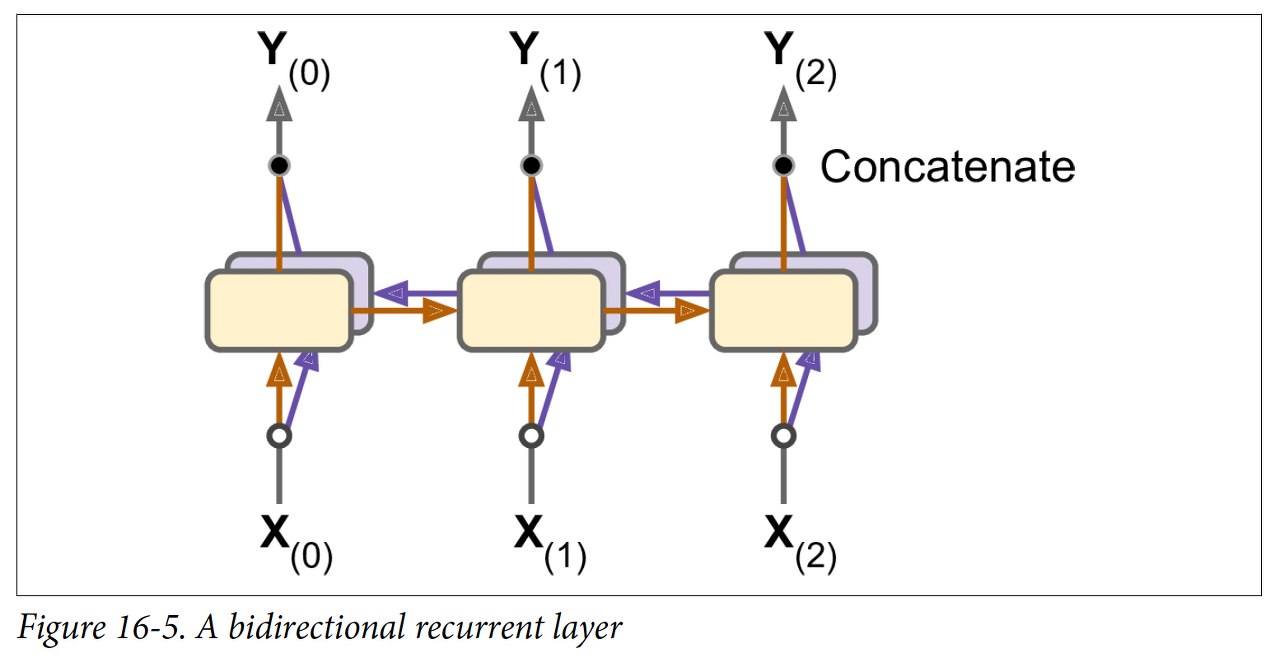

기존 RNN은 과거에서 현재 순으로 입력이 들어간다. 한마디로 causal하다. 미래를 보지 않는다.

time series를 예측할 때는 기존 RNN의 방식이 맞아보이지만, 기계번역같은 NLP task에서는 주어진 단어가 인코딩 되기 전에 다음 단어를 보는 것이 선호된다.

예를 들어 the queen of hearts와 같은 단어구를 번역하려면 뒤에 단어를 봐야한다.

이를 구현하기 위해서는 그냥 간단하게 같은 입력을 왼쪽에서 오른쪽으로 통과시키는 layer, 오른쪽에서 왼쪽으로 통과시키는 layer를 만들면 된다.

그다음 출력을 같은 시간에 맞게 연결하기만 하면된다. 입력이 10이면 출력이 20이 된다.

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


## Beam Search

Comment vas-tu라는 문장을 번역하면 how are you로 번역하길 원하지만 how will you로 번역된다.

이는 train set에 commnet vas의 정답으로 how will이 많기 때문이다.

이러한 문제를 막기 위해서 모델은 뒤로 다시 돌아가서 고칠 수 없다.

그러므로 최대한 문장을 잘 만들 노력을 해야한다.

매 스탭마다 제일 확률 높은 단어를 출력하는 것은 suboptimal한 번역을 한다.

어떻게 모델이 뒤로 가서 다시 고칠 수 있는 기회를 줄 수 있을까? beam search

매 스텝마다 가장 좋은 문장을 약속하는 top k 개의 list를 계속 가져간다.

k는 beam width
 
예시 문장 Comment vas-tu, k는 3

첫 스텝 how 75%, what 3%, you 1%

모델 3개를 복사한다.

처음 모델은 how 다음에 will 36%, are 32%, do 16%의 확률을 출력한다.

두번째 모델은 what 다음에 are 50%

두 스텝에 대해 경우에 따라 확률이 구해졌으면 확률들을 곱해 조건부 확률을 만든다.

how will 75% * 36% = 27%

how are 24%

how do 12%

확률은 how will이 제일 높지만 how are은 제거되지 않는다.
 
이 과정을 반복하면

how are you 10%

how do you 8%

how will you 2%

다음 스텝까지 하면

how do you do 7%

how are you <eos> 6%

how are you doing 3%

합리적인 번역을 위해 3개만 가지고 있기 때문에 how will은 제거된다.

# Attention Mechanisms

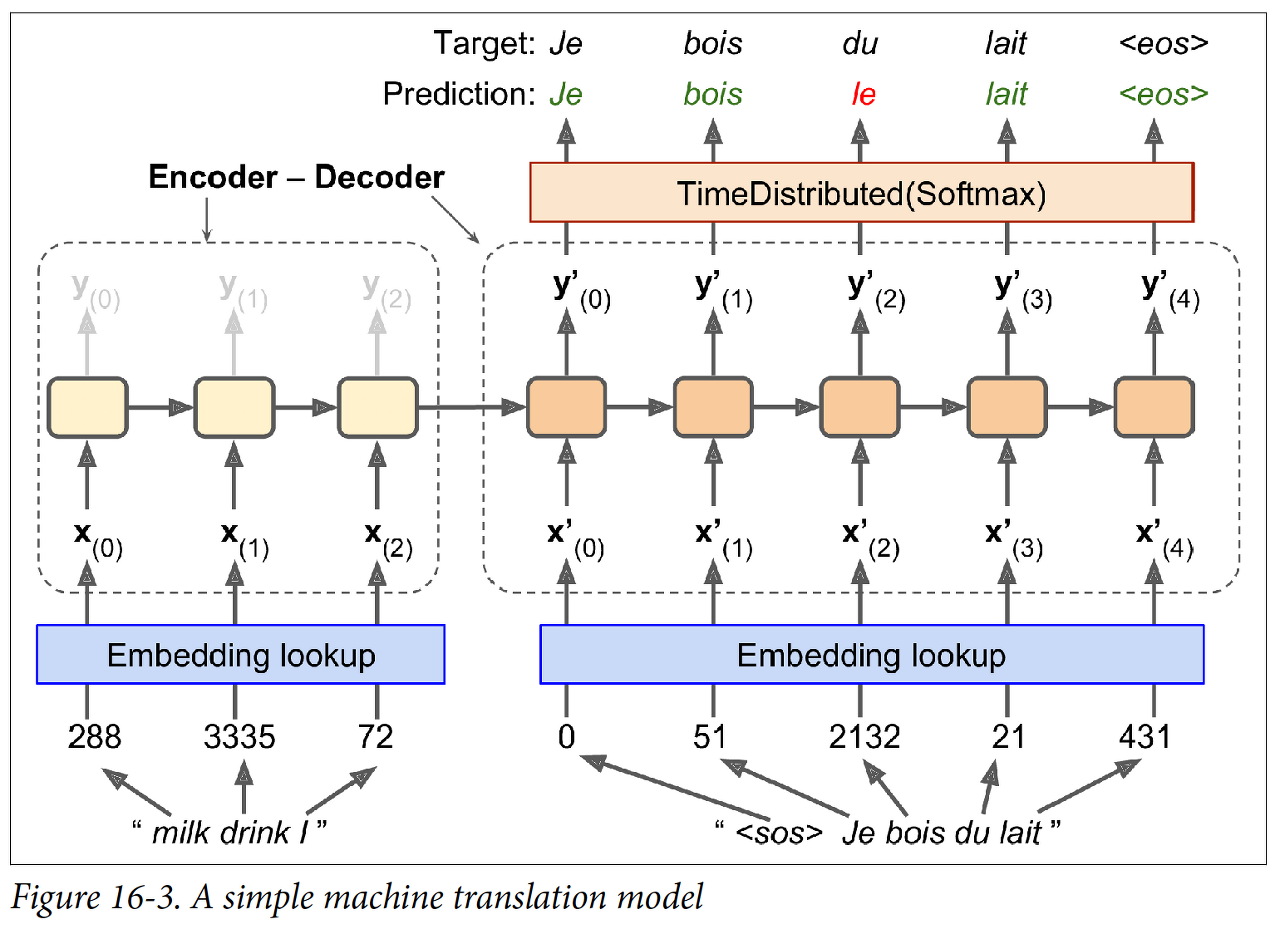

milk가 lait으로 번역되는 과정이 너무 길다!

제일 먼저 인코딩되었던 단어가 디코딩되어 번역되기 전까지 매우 많은 스텝을 거쳐야 한다.

디코더가 매 스텝마다 인코더의 정확한 단어에 집중할 수 있는 방법이 제안되었다.

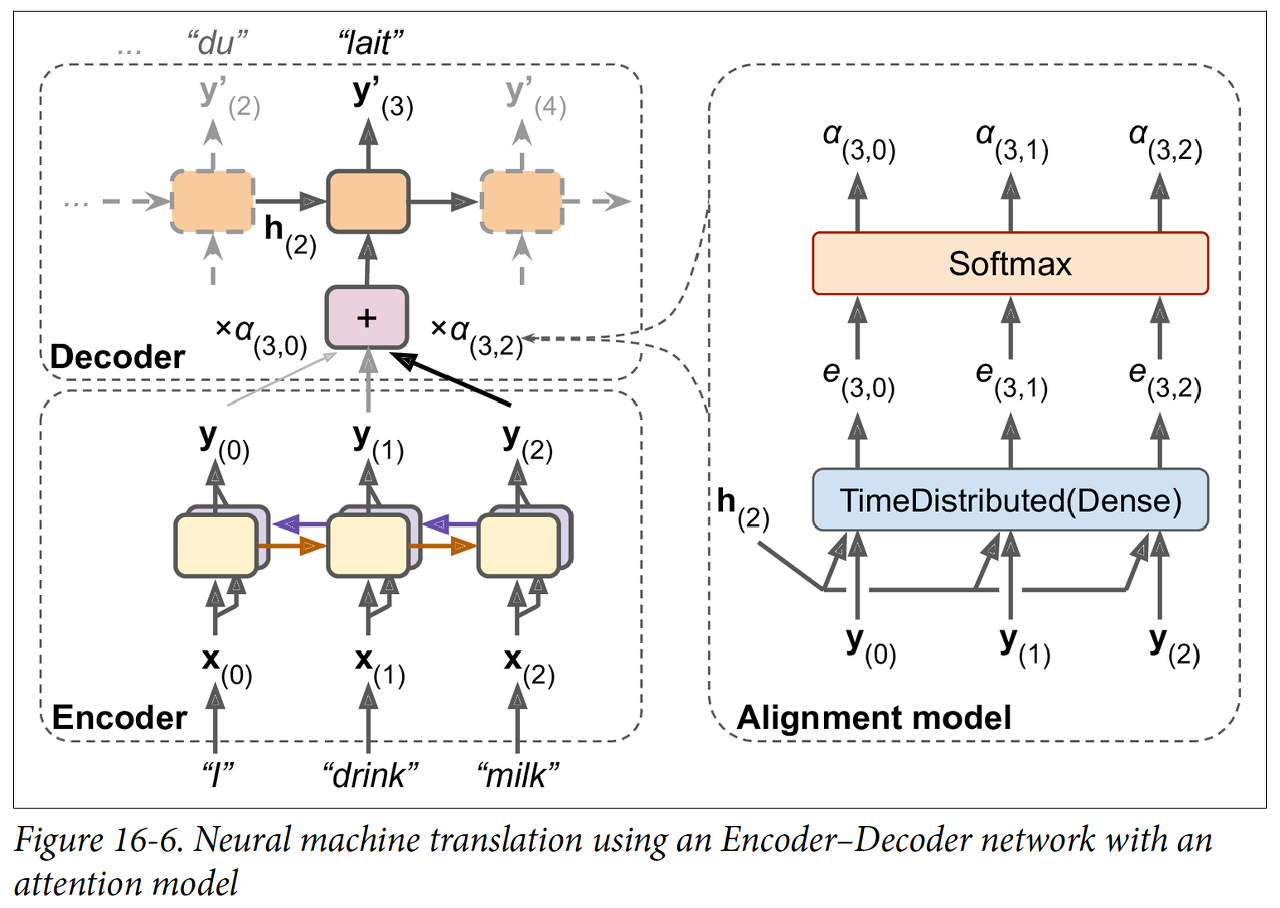

왼쪽에 인코더 디코더가 있는데 바뀐 점은 인코더의 마지막 state를 디코더로 넘기는 것 대신에 인코더들의 출력을 디코더로 보낸다.

매 스텝마다 디코더는 모든 인코더의 출력의 weighted sum을 계산한다. 어떠한 단어에 집중할지를 결정하는 

weight a(t, i)는 t 디코더 스텝의 i 인코더 출력

만약 weight a(3, 2)가 weight a(3, 0)와 weight a(3, 1)보다 크다면, 디코더는 "milk"에 더 집중할 것이다.

weight a는 alignment model(attention layer)라는 작은 모델에서 생성된다.

single neuron의 TimeDistributed dense layer에서 인코더의 모든 아웃풋과 디코더의 이전 스테이트를 concatenate해서 dense layer를 통과한다. attention score

이 score는 얼마나 잘 각 출력이 디코더의 이전 히든 스테이트와 함께 정렬되었는지를 말한다.

마지막으로 소프트맥스를 통과하여 인코더의 출력과 weighted sum해서 입력으로 들어간다.

Bahdanau (바흐다나우) attention 또는 concatenative (연결) attention이라고 불린다.
 
그 다음 제안된 것은 인코더의 출력과 디코더의 이전 히든 스테이트간에 similarity를 측정하는 것을 목표로 하였다.

concatenate 대신 dot product를 해서 score를 구함.

Luong (루옹) attention 또는 multiplicative attention

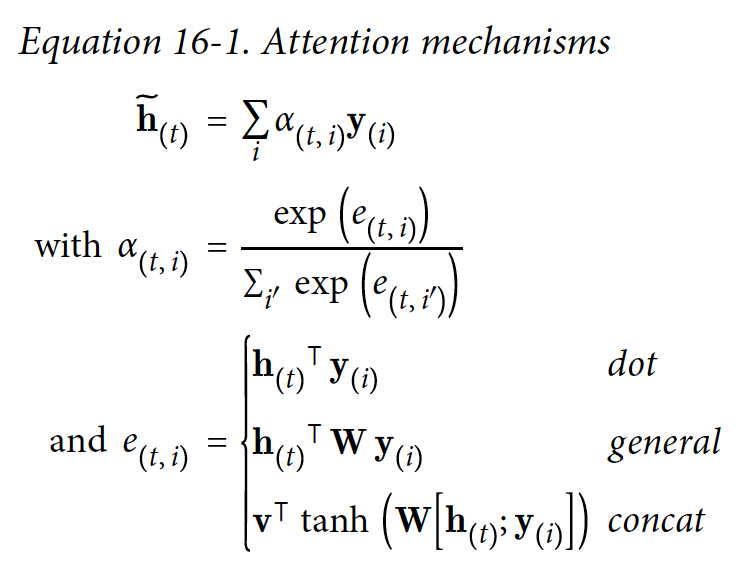

## Visual Attention

어텐션 메커니즘이 NMT 말고 이미지 캡션을 만들 때도 사용될 수 있다.

이미지를 CNN으로 통과시키고 어텐션 기반의 decoder RNN으로 캡션을 만들 수 있다.

모델이 캡션 "A woman is throwing a frisbee in a park."를 생성 했을 때 예

디코더가 frisbee를 출력할 때 입력 이미지의 어떤 부분에 초점을 맟주고 있는지 볼 수 있음.

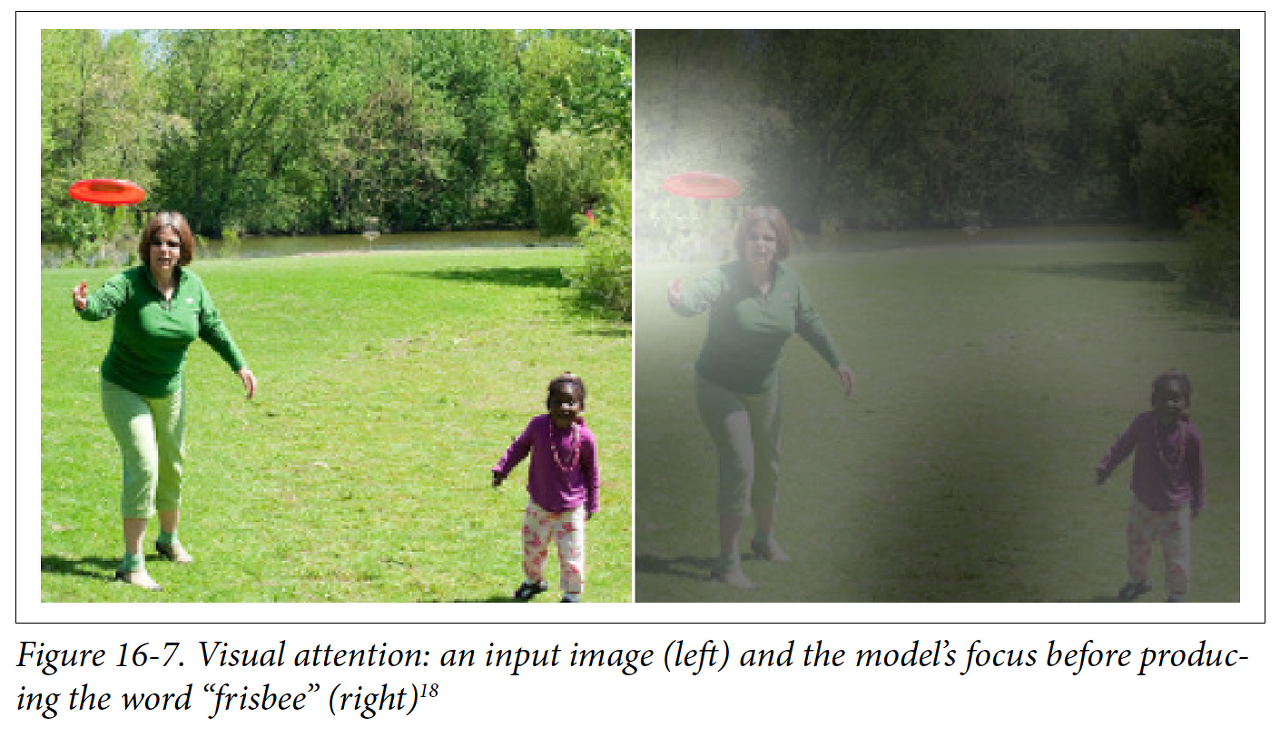

## Attention Is All You Need: The Transformer Architecture

Transformer

RNN과 CNN을 사용하지 않고 어텐션만 이용해서 성능을 높임.

학습도 빠르고 병렬화 하기도 쉽다

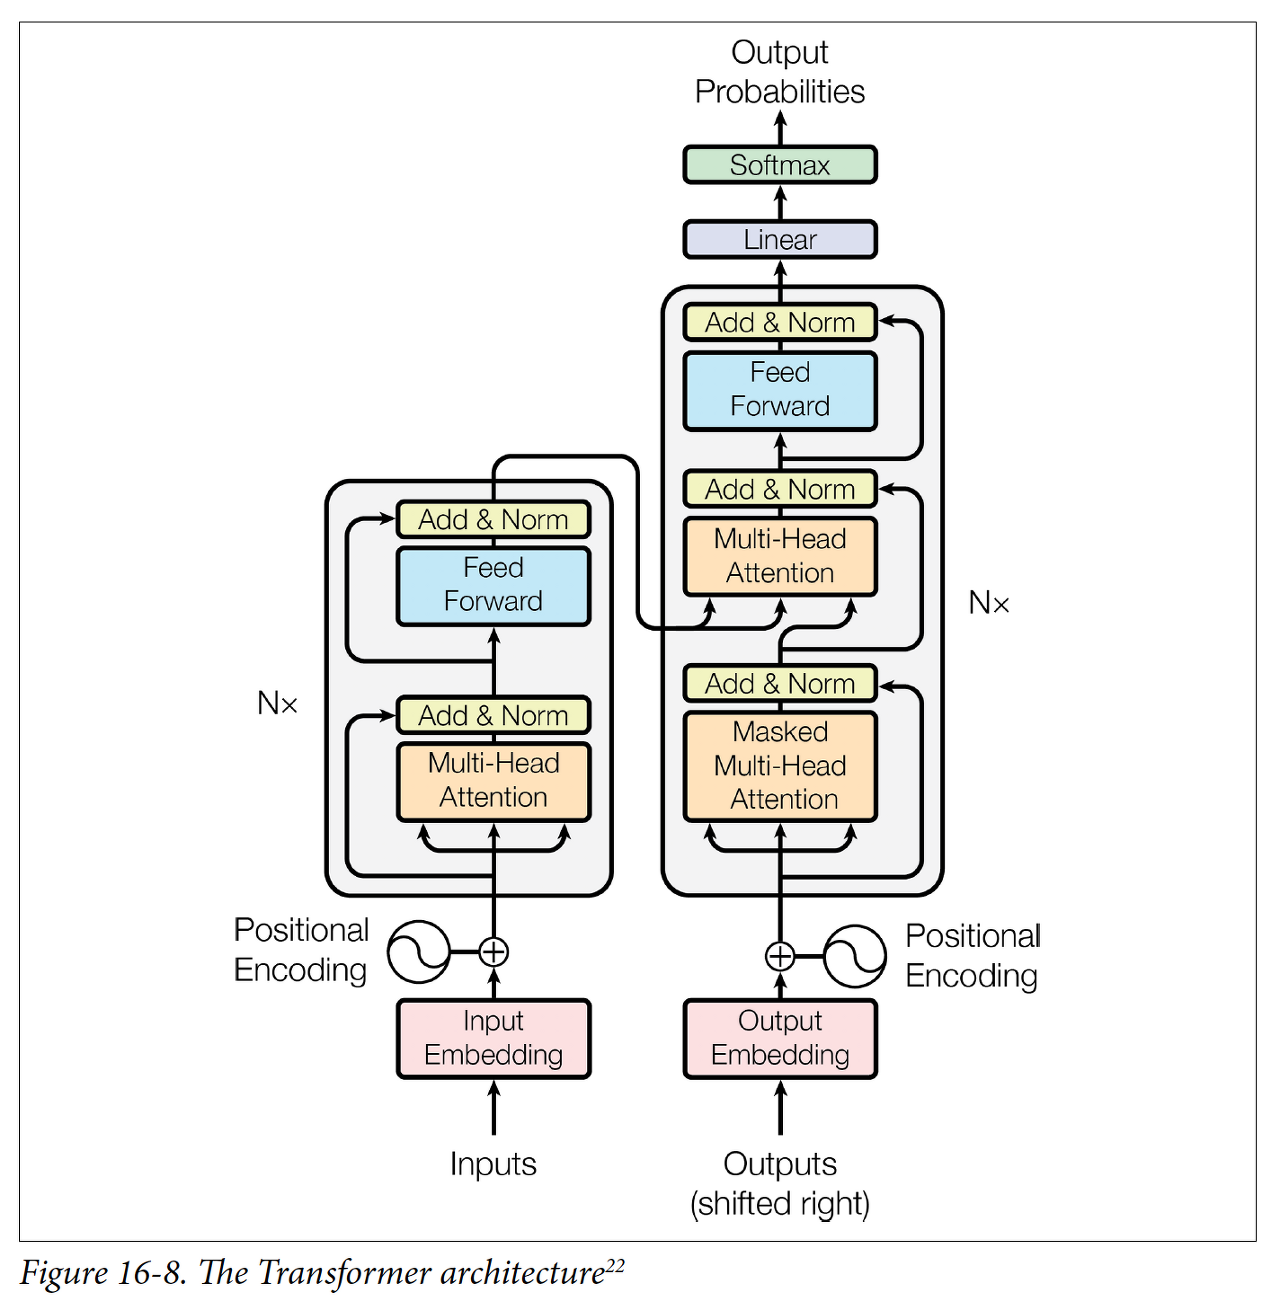

왼쪽에는 인코더부분

인코더 input으로 [batch size, max input sentence length]

인코더 output으로 [batch size, max input sentence length, 512]

N개만큼 인코더가 쌓이고, N은 논문에서 6 사용
 
오른쪽에는 디코더부분

학습하는 동안 디코더 input으로 1 time step 쉬프트된 타겟 문장

인코더의 output도 입력으로 받음

디코더도 N개만큼 쌓임

N개의 인코더 출력이 각각 N개의 디코더 입력으로 들어감 

출력은 다음 단어에 대한 확률 [batch size, max output sentence length, vocabulary length]
 
inference 동안 디코터는 타겟들을 입력으로 넣어줄 수 없다. 그래서 이전 출력 단어를 입력으로 사용한다.

2 embedding layers

5 * N skip connections (+ layer normalization layer)

2 * N feed forward (2 dense layer, first ReLU, second none)

1 dense layer, 1 softmax function

all layers time distributed
> 새로운 요소1 - Multi-Head Attention layer

인코더의 Multi-Head Attention layer는 같은 문장 안에 모든 다른 단어에 대해 각 단어의 관계를 인코딩한다.

예를 들어 "They welcomed the Queen of the United Kingdom"라는 문장 안에 "Queen"에 대한 이 layer의 출력은 문장 안에 모든 단어에 의존한다

하지만 그것은 "They" 또는 "welcomed"보다는 "United"와 "Kingdom"에 어텐션을 더 줄 것이다.

이 어텐션 메카니즘은 "self-attention"이라고 불린다.

디코더의 Masked Multi-Head Attention layer도 같은 동작을 한다. 그러나 각 단어는 오직 그 단어 이전에 위치한 단어에만 참석하는 것을 허락한다.

두번째 Multi-Head Attention layer에서 드디어 input sequence에 어텐션을 준다.

> 새로운 요소2 - Positional embeddings

Positional embeddings는 간단하게는 문장에서 단어의 위치를 나타내는 dense vector들이다. (word embeddings 같은)

nth positional embedding은 각 문장에 nth word의 word embedding이 더해진다.

이것은 모델이 각 단어의 위치에 접근하게 한다. 왜냐하면 Multi-Head Attention layer들은 단어들의 순서나 위치를 고려하지 않기 때문에. 오직 관계만 쳐다본다.

RNN은 시간적 연속성을 보장해줬다.

### Positional Encoding

만약 위치의 정보를 단순하게 1, 2, 3, 4 이런식으로 부여하면 큰 숫자가 모델의 입력으로 사용되고 이것은 좋지 않은 영향을 끼친다.

그래서 모델 학습에 방해가 되지 않으면서 위치 정보를 부여할 수 있는 방법을 생각.

ith positional embedding은 간단하게 ith word embedding에 더해진다.

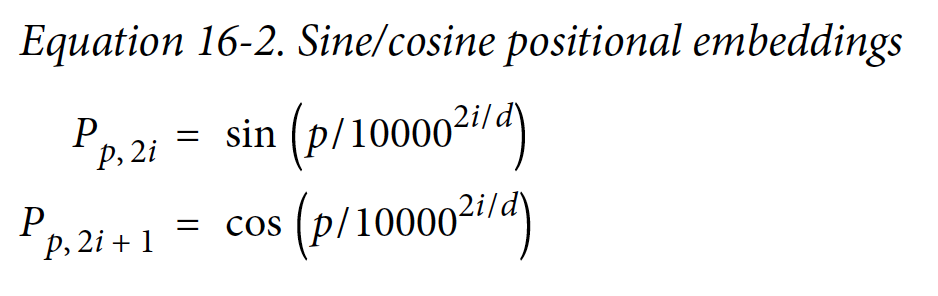

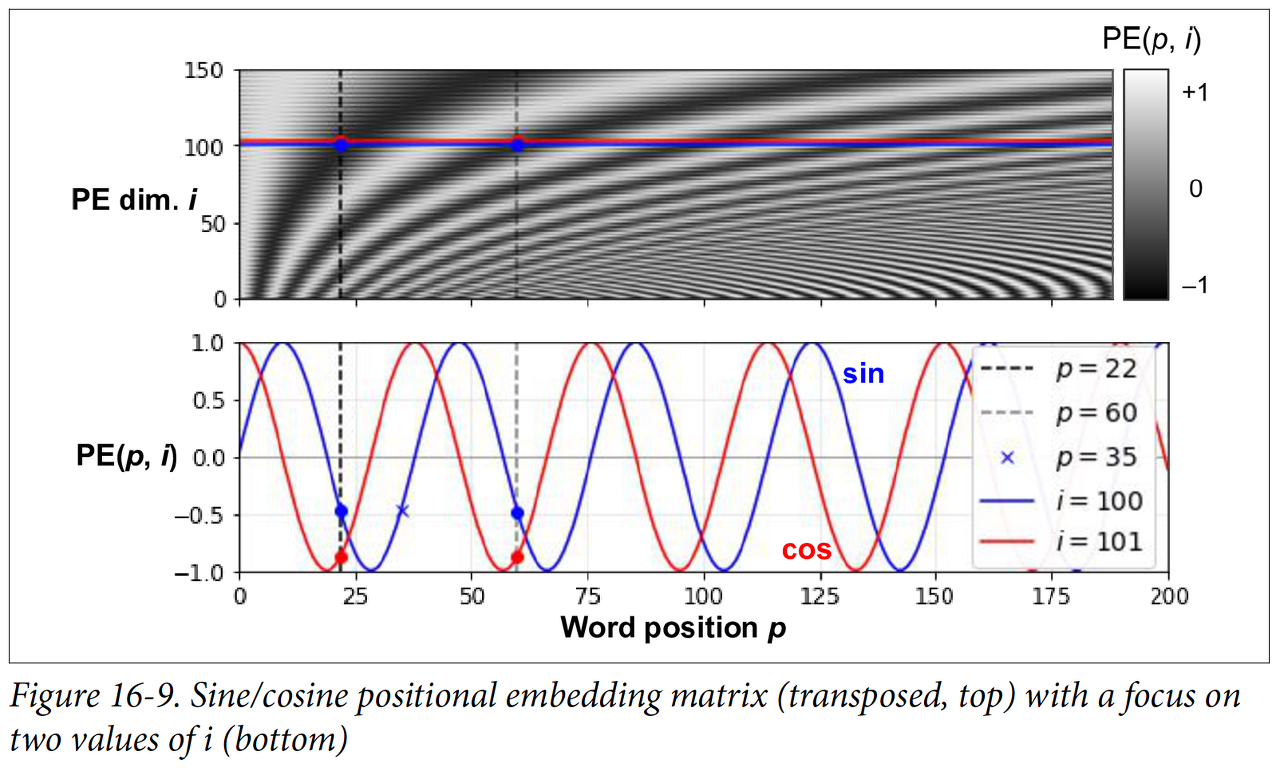

그림 16-9를 보면 word position p에 따라 단어의 위치에 따라 PE (positional embedding)의 값이 바뀌고 이는 위치에 따라 유니크하다.

또한 값이 -1 ~ 1로 존재해 모델 학습에 안 좋은 영향을 끼치지 않는다. sine, cosine과 같은 oscillating functions은 모델이 상대적인 위치를 학습하는 것을 가능하게 해준다.

또한 문장의 길이가 길어져도 확장이 가능하다.

그림 16-9에서 22번과 60번 위치를 보자. i가 100, 101일 때 PE 값이 같지만 전체의 PE를 보면 유니크하다.

In [20]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        print(self.positional_embedding.shape, shape, shape[-2], shape[-1])
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [21]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

(1, 201, 512) tf.Tensor([  1 201 512], shape=(3,), dtype=int32) tf.Tensor(201, shape=(), dtype=int32) tf.Tensor(512, shape=(), dtype=int32)


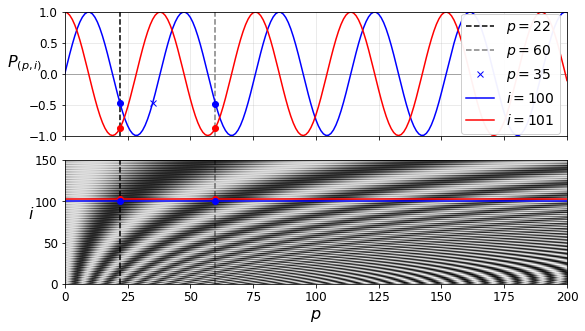

In [5]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [6]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

### Multi-Head Attention

먼저 Scaled Dot-Product Attention layer를 이해해야 한다.

번역을 하기 위해서는 인코더가 인풋 시퀀스를 분석해야한다. "They played chess," -> {"subject": "They", "verb": "played", ...} 이렇게 인코더가 분석을 해야한다. they는 주어 played는 동사.

디코더는 이미 주어를 번역했고 다음으로 동사가 번역되어야 한다고 생각한다. 그러면 인풋에서 동사가 어디 있나 찾아야 한다.

디코더는 verb라는 key를 보고 이해하면 된다. 하지만 모델은 이렇게 discrete한 token들을 가지고 있지 않다. vector로 표현된 key를 가지고 있고 이를 query라고 한다.

look up에 사용될 key(query)는 딕셔너리에 정확히 일치하지 않는다. 그래서 query와 딕셔너리의 key의 similarity를 구한다. 그다음 소프트맥스 함수를 사용해서 similarity score를 합 1로 바꿔준다.

모델은 다시 similarity와 value의 weighted sum을 구한다.

Transformer 모델에서 사용되는 similarity measure는 그냥 dot product다. (scaling factor만 추가된)

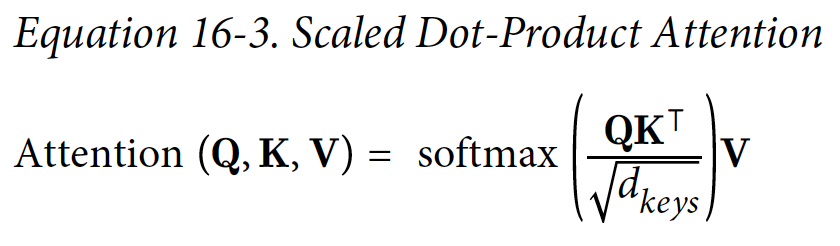

Q는 query다. [n_queries, d_keys]

K는 key다. [n_keys, d_keys]

V는 value다. [n_keys, d_values]

QK^T는 [n_queries, n_keys] 모양이고, 각 query와 key의 similarity score. 소프트맥스 함수를 거치기 때문에 각 query마다 합이 1이고 최종 출력은 [n_queries, d_values]. 행은 각 query의 결과

Scaling factor는 그레디언트를 작게 만드는 소프트맥스 함수의 saturation을 피하기 위해 사용한다.

소프트맥스 지나기 전에 Similarity score에 매우 큰 음수를 더함으로써 마스킹할 수 있다. Masked Multi-Head Attention layer.

인코더에서 이 식에서 Q, K, V는 모두 인풋 시퀀스의 단어 리스트다. (그래서 문장에 각 단어들은 본인 문장에 모든 단어들과의 관계를 학습하게 된다. 본인 단어 포함)

비슷하게 디코더의 마스킹된 어텐션 레이어는 Q, K, V는 모두 타겟 시퀀스의 단어 리스트다. 그런데 inference를 할 때는 미래의 출력이 없기 때문에 학습할 때 마찬가지로 미래의 타겟 시퀀스는 마스킹 된 상태로 학습되어야한다.

디코더에서 위에 있는 어텐션 레이어의 K와 V는 인코더에서 만들어진 word encodings이다. (인코더의 출력) Q는 디코더에서 만들어진 word encodings이다.



Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [7]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

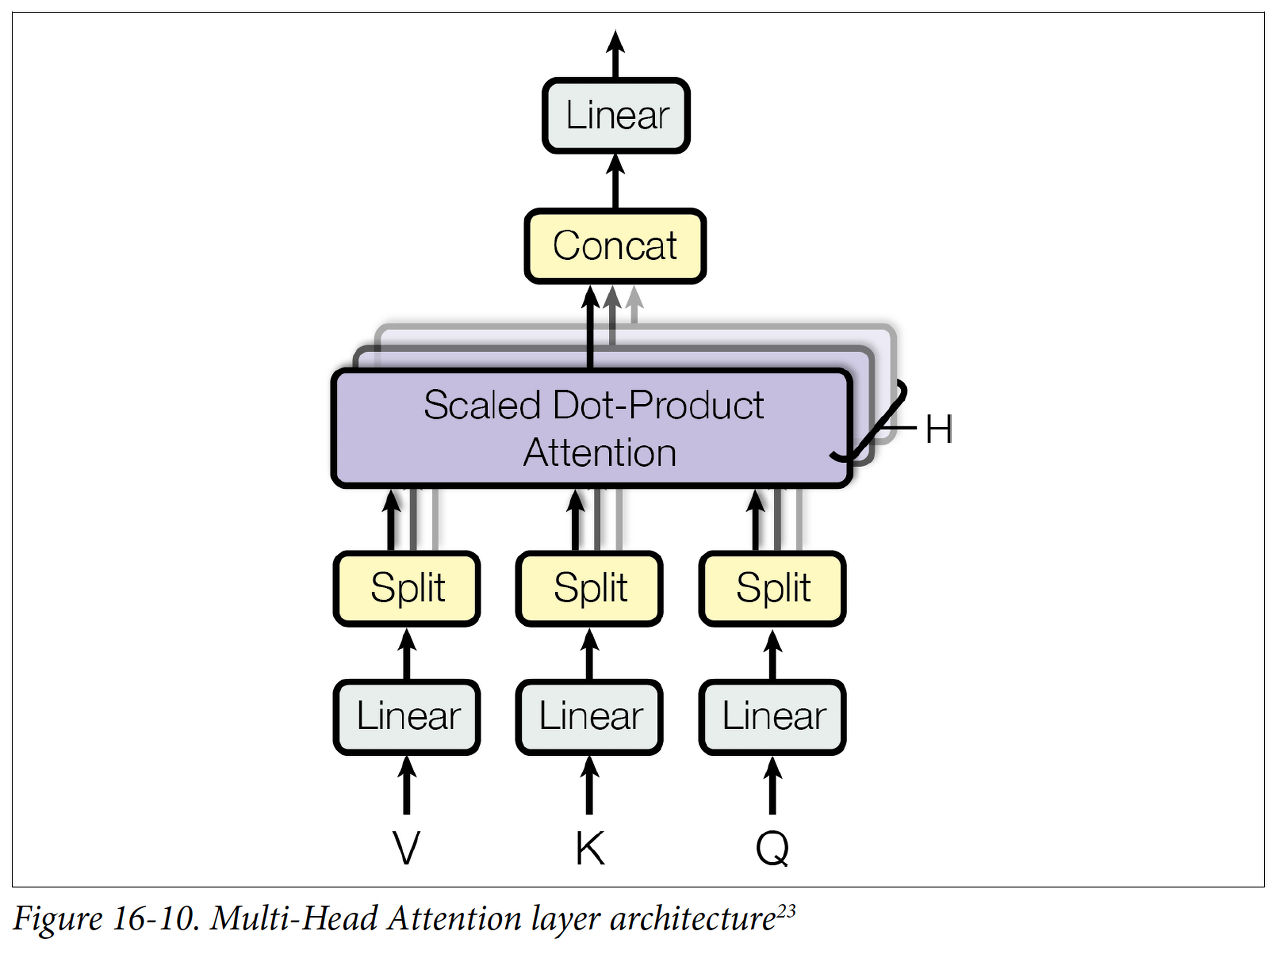

Mulit-Head Attention layer는 단순히 scaled dot-product attention layer를 겹쳐 놓은 것이다.

입력을 linear transform하고 출력을 합쳐서 다시 linear transform

왜 그럴까?

인코더는 똑똑해서 단어에서 다양한 특성을 포함한다.

품사

position 등등

만약 multi가 아니라 single로 attention layer를 사용한다면 하나의 특성만 query할 것이다. (요청?)

그래서 다양한 linear transform을 통해 다양한 subspace들로 projection해서 모델이 적용할 수 있다. word의 특성의 서브셋에 집중한 subspace

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [8]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [9]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape

TensorShape([2, 50, 512])

# Exercise solutions

## 1. to 7.

See Appendix A.

## 8.
_Exercise:_ Embedded Reber grammars _were used by Hochreiter and Schmidhuber in [their paper](https://homl.info/93) about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's [nice introduction](https://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't._

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [ ]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [ ]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

We cannot feed strings directly to an RNN, so we need to encode them somehow. One option would be to one-hot encode each character. Another option is to use embeddings. Let's go for the second option (but since there are just a handful of characters, one-hot encoding would probably be a good option as well). For embeddings to work, we need to convert each string into a sequence of character IDs. Let's write a function for that, using each character's index in the string of possible characters "BEPSTVX":

In [ ]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [POSSIBLE_CHARS.index(c) for c in s]

In [ ]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

We can now generate the dataset, with 50% good strings, and 50% bad strings:

In [ ]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [ ]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

Let's take a look at the first training sequence:

In [ ]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

What classes does it belong to?

In [ ]:
y_train[0]

array([1.])

Perfect! We are ready to create the RNN to identify good strings. We build a simple sequence binary classifier:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# TF 2.2 & cuDNN 7.6.5에서 에러가 발생하기 때문에 CPU로 실행합니다.
with tf.device('/CPU'):
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


313/313 [==============================] - 8s 20ms/step - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6825 - val_accuracy: 0.5645
Epoch 2/20
313/313 [==============================] - 6s 18ms/step - loss: 0.6757 - accuracy: 0.5485 - val_loss: 0.6635 - val_accuracy: 0.6105
Epoch 3/20
313/313 [==============================] - 6s 19ms/step - loss: 0.6511 - accuracy: 0.5818 - val_loss: 0.6521 - val_accuracy: 0.6110
Epoch 4/20
313/313 [==============================] - 6s 19ms/step - loss: 0.6449 - accuracy: 0.5752 - val_loss: 0.6224 - val_accuracy: 0.6445
Epoch 5/20
313/313 [==============================] - 6s 19ms/step - loss: 0.6154 - accuracy: 0.6287 - val_loss: 0.5779 - val_accuracy: 0.6980
Epoch 6/20
313/313 [==============================] - 6s 19ms/step - loss: 0.5612 - accuracy: 0.6940 - val_loss: 0.4695 - val_accuracy: 0.7795
Epoch 7/20
313/313 [==============================] - 6s 19ms/step - loss: 0.4228 - accuracy: 0.8126 - val_loss: 0.2626 - val_accuracy: 0.9115
Epoch 8/20

Now let's test our RNN on two tricky strings: the first one is bad while the second one is good. They only differ by the second to last character. If the RNN gets this right, it shows that it managed to notice the pattern that the second letter should always be equal to the second to last letter. That requires a fairly long short-term memory (which is the reason why we used a GRU cell).

In [ ]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

# TF 2.2 & cuDNN 7.6.5에서 에러가 발생하기 때문에 CPU로 실행합니다.
with tf.device('/CPU'):
    y_proba = model.predict(X_test)

print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))

Ta-da! It worked fine. The RNN found the correct answers with very high confidence. :)

## 9.
_Exercise: Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22")._

Let's start by creating the dataset. We will use random days between 1000-01-01 and 9999-12-31:

In [ ]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

Here are a few random dates, displayed in both the input format and the target format:

In [ ]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Let's get the list of all possible characters in the inputs:

In [ ]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "01234567890, "
INPUT_CHARS

And here's the list of possible characters in the outputs:

In [ ]:
OUTPUT_CHARS = "0123456789-"

Let's write a function to convert a string to a list of character IDs, as we did in the previous exercise:

In [ ]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [ ]:
date_str_to_ids(x_example[0], INPUT_CHARS)

In [ ]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

In [ ]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [ ]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [ ]:
Y_train[0]

### First version: a very basic seq2seq model

Let's first try the simplest possible model: we feed in the input sequence, which first goes through the encoder (an embedding layer followed by a single LSTM layer), which outputs a vector, then it goes through a decoder (a single LSTM layer, followed by a dense output layer), which outputs a sequence of vectors, each representing the estimated probabilities for all possible output character.

Since the decoder expects a sequence as input, we repeat the vector (which is output by the decoder) as many times as the longest possible output sequence.

In [ ]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Looks great, we reach 100% validation accuracy! Let's use the model to make some predictions. We will need to be able to convert a sequence of character IDs to a readable string:

In [ ]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

Now we can use the model to convert some dates

In [ ]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [ ]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

Perfect! :)

However, since the model was only trained on input strings of length 18 (which is the length of the longest date), it does not perform well if we try to use it to make predictions on shorter sequences:

In [ ]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [ ]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

Oops! We need to ensure that we always pass sequences of the same length as during training, using padding if necessary. Let's write a little helper function for that:

In [ ]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict_classes(X)
    return ids_to_date_strs(ids)

In [ ]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

Cool! Granted, there are certainly much easier ways to write a date conversion tool (e.g., using regular expressions or even basic string manipulation), but you have to admit that using neural networks is way cooler. ;-)

However, real-life sequence-to-sequence problems will usually be harder, so for the sake of completeness, let's build a more powerful model.

### Second version: feeding the shifted targets to the decoder (teacher forcing)

Instead of feeding the decoder a simple repetition of the encoder's output vector, we can feed it the target sequence, shifted by one time step to the right. This way, at each time step the decoder will know what the previous target character was. This should help is tackle more complex sequence-to-sequence problems.

Since the first output character of each target sequence has no previous character, we will need a new token to represent the start-of-sequence (sos).

During inference, we won't know the target, so what will we feed the decoder? We can just predict one character at a time, starting with an sos token, then feeding the decoder all the characters that were predicted so far (we will look at this in more details later in this notebook).

But if the decoder's LSTM expects to get the previous target as input at each step, how shall we pass it it the vector output by the encoder? Well, one option is to ignore the output vector, and instead use the encoder's LSTM state as the initial state of the decoder's LSTM (which requires that encoder's LSTM must have the same number of units as the decoder's LSTM).

Now let's create the decoder's inputs (for training, validation and testing). The sos token will be represented using the last possible output character's ID + 1.

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

Let's take a look at the decoder's training inputs:

In [ ]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

Now let's build the model. It's not a simple sequential model anymore, so let's use the functional API:

In [ ]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 7s 12ms/step - loss: 1.9469 - accuracy: 0.3099 - val_loss: 1.4141 - val_accuracy: 0.4604
Epoch 2/10
313/313 [==============================] - 3s 10ms/step - loss: 1.3265 - accuracy: 0.5033 - val_loss: 0.8941 - val_accuracy: 0.6844
Epoch 3/10
313/313 [==============================] - 3s 10ms/step - loss: 0.7480 - accuracy: 0.7348 - val_loss: 0.3754 - val_accuracy: 0.8739
Epoch 4/10
313/313 [==============================] - 3s 10ms/step - loss: 0.2842 - accuracy: 0.9238 - val_loss: 0.0956 - val_accuracy: 0.9888
Epoch 5/10
313/313 [==============================] - 3s 10ms/step - loss: 0.1003 - accuracy: 0.9855 - val_loss: 0.0401 - val_accuracy: 0.9984
Epoch 6/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0317 - accuracy: 0.9993 - val_loss: 0.0212 - val_accuracy: 0.9998
Epoch 7/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0648 - accuracy: 0.9892 - val_loss: 0.0156 - val_accuracy: 0.9999

This model also reaches 100% validation accuracy, but it does so even faster.

Let's once again use the model to make some predictions. This time we need to predict characters one by one.

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Works fine! :)

### Third version: using TF-Addons's seq2seq implementation

Let's build exactly the same model, but using TF-Addon's seq2seq API. The implementation below is almost very similar to the TFA example higher in this notebook, except without the model input to specify the output sequence length, for simplicity (but you can easily add it back in if you need it for your projects, when the output sequences have very different lengths).

In [ ]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 16s 40ms/step - loss: 1.9227 - accuracy: 0.3130 - val_loss: 1.4580 - val_accuracy: 0.4299
Epoch 2/15
313/313 [==============================] - 12s 39ms/step - loss: 1.4092 - accuracy: 0.4481 - val_loss: 1.2117 - val_accuracy: 0.5440
Epoch 3/15
313/313 [==============================] - 13s 41ms/step - loss: 1.0563 - accuracy: 0.6161 - val_loss: 0.6265 - val_accuracy: 0.7847
Epoch 4/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4898 - accuracy: 0.8364 - val_loss: 0.2264 - val_accuracy: 0.9459
Epoch 5/15
313/313 [==============================] - 12s 38ms/step - loss: 0.1507 - accuracy: 0.9713 - val_loss: 0.0685 - val_accuracy: 0.9939
Epoch 6/15
313/313 [==============================] - 12s 38ms/step - loss: 0.0511 - accuracy: 0.9975 - val_loss: 0.0387 - val_accuracy: 0.9970
Epoch 7/15
313/313 [==============================] - 12s 39ms/step - loss: 0.0240 - accuracy: 0.9997 - val_loss: 0.0176 - val_accuracy:

And once again, 100% validation accuracy! To use the model, we can just reuse the `predict_date_strs()` function:

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

However, there's a much more efficient way to perform inference. Until now, during inference, we've run the model once for each new character. Instead, we can create a new decoder, based on the previously trained layers, but using a `GreedyEmbeddingSampler` instead of a `TrainingSampler`.

At each time step, the `GreedyEmbeddingSampler` will compute the argmax of the decoder's outputs, and run the resulting token IDs through the decoder's embedding layer. Then it will feed the resulting embeddings to the decoder's LSTM cell at the next time step. This way, we only need to run the decoder once to get the full prediction.

In [ ]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

A few notes:
* The `GreedyEmbeddingSampler` needs the `start_tokens` (a vector containing the start-of-sequence ID for each decoder sequence), and the `end_token` (the decoder will stop decoding a sequence once the model outputs this token).
* We must set `maximum_iterations` when creating the `BasicDecoder`, or else it may run into an infinite loop (if the model never outputs the end token for at least one of the sequences). This would force you would to restart the Jupyter kernel.
* The decoder inputs are not needed anymore, since all the decoder inputs are generated dynamically based on the outputs from the previous time step.
* The model's outputs are `final_outputs.sample_id` instead of the softmax of `final_outputs.rnn_outputs`. This allows us to directly get the argmax of the model's outputs. If you prefer to have access to the logits, you can replace `final_outputs.sample_id` with `final_outputs.rnn_outputs`.

Now we can write a simple function that uses the model to perform the date format conversion:

In [ ]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [ ]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Let's check that it really is faster:

In [ ]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

1 loop, best of 5: 418 ms per loop


In [ ]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

10 loops, best of 5: 41.3 ms per loop


That's more than a 10x speedup! And it would be even more if we were handling longer sequences.

### Fourth version: using TF-Addons's seq2seq implementation with a scheduled sampler

**Warning**: due to a TF bug, this version only works using TensorFlow 2.2.

When we trained the previous model, at each time step _t_ we gave the model the target token for time step _t_ - 1. However, at inference time, the model did not get the previous target at each time step. Instead, it got the previous prediction. So there is a discrepancy between training and inference, which may lead to disappointing performance. To alleviate this, we can gradually replace the targets with the predictions, during training. For this, we just need to replace the `TrainingSampler` with a `ScheduledEmbeddingTrainingSampler`, and use a Keras callback to gradually increase the `sampling_probability` (i.e., the probability that the decoder will use the prediction from the previous time step rather than the target for the previous time step).

In [ ]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_3:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_5:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/

313/313 [==============================] - 24s 64ms/step - loss: 1.9227 - accuracy: 0.3130 - val_loss: 1.4556 - val_accuracy: 0.4326
Epoch 2/20
313/313 [==============================] - 20s 63ms/step - loss: 1.4279 - accuracy: 0.4415 - val_loss: 1.2236 - val_accuracy: 0.5451
Epoch 3/20
313/313 [==============================] - 20s 63ms/step - loss: 1.1775 - accuracy: 0.5706 - val_loss: 0.8689 - val_accuracy: 0.6821
Epoch 4/20
313/313 [==============================] - 20s 63ms/step - loss: 0.7631 - accuracy: 0.7213 - val_loss: 0.4834 - val_accuracy: 0.8217
Epoch 5/20
313/313 [==============================] - 20s 63ms/step - loss: 0.4274 - accuracy: 0.8458 - val_loss: 0.3200 - val_accuracy: 0.8939
Epoch 6/20
313/313 [==============================] - 19s 62ms/step - loss: 0.2659 - accuracy: 0.9163 - val_loss: 0.1775 - val_accuracy: 0.9505
Epoch 7/20
313/313 [==============================] - 19s 62ms/step - loss: 0.1775 - accuracy: 0.9536 - val_loss: 0.1140 - val_accuracy: 0.9717
Epo

Not quite 100% validation accuracy, but close enough!

For inference, we could do the exact same thing as earlier, using a `GreedyEmbeddingSampler`. However, just for the sake of completeness, let's use a `SampleEmbeddingSampler` instead. It's almost the same thing, except that instead of using the argmax of the model's output to find the token ID, it treats the outputs as logits and uses them to sample a token ID randomly. This can be useful when you want to generate text. The `softmax_temperature` argument serves the 
same purpose as when we generated Shakespeare-like text (the higher this argument, the more random the generated text will be).

In [ ]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [ ]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [ ]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

Dates look good at room temperature. Now let's heat things up a bit:

In [ ]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
                           temperature=5.)

Oops, the dates are overcooked, now. Let's call them "creative" dates.

### Fifth version: using TFA seq2seq, the Keras subclassing API and attention mechanisms

The sequences in this problem are pretty short, but if we wanted to tackle longer sequences, we would probably have to use attention mechanisms. While it's possible to code our own implementation, it's simpler and more efficient to use TF-Addons's implementation instead. Let's do that now, this time using Keras' subclassing API.

**Warning**: due to a TensorFlow bug (see [this issue](https://github.com/tensorflow/addons/issues/1153) for details), the `get_initial_state()` method fails in eager mode, so for now we have to use the subclassing API, as Keras automatically calls `tf.function()` on the `call()` method (so it runs in graph mode).

In this implementation, we've reverted back to using the `TrainingSampler`, for simplicity (but you can easily tweak it to use a `ScheduledEmbeddingTrainingSampler` instead). We also use a `GreedyEmbeddingSampler` during inference, so this class is pretty easy to use:

In [ ]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(
            input_dim=len(INPUT_CHARS) + 1,
            output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        self.decoder_embedding = keras.layers.Embedding(
            input_dim=len(OUTPUT_CHARS) + 2,
            output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=decoder_inner_cell,
            attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),
            output_layer=output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
                embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length)

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_outputs,
                       setup_memory=True)
        
        decoder_embeddings = self.decoder_embedding(decoder_input)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)
        
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        return tf.nn.softmax(decoder_outputs.rnn_output)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Not quite 100% validation accuracy, but close. It took a bit longer to converge this time, but there were also more parameters and more computations per iteration. And we did not use a scheduled sampler.

To use the model, we can write yet another little function:

In [ ]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [ ]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['----------', '----------']

There are still a few interesting features from TF-Addons that you may want to look at:
* Using a `BeamSearchDecoder` rather than a `BasicDecoder` for inference. Instead of outputing the character with the highest probability, this decoder keeps track of the several candidates, and keeps only the most likely sequences of candidates (see chapter 16 in the book for more details).
* Setting masks or specifying `sequence_length` if the input or target sequences may have very different lengths.
* Using a `ScheduledOutputTrainingSampler`, which gives you more flexibility than the `ScheduledEmbeddingTrainingSampler` to decide how to feed the output at time _t_ to the cell at time _t_+1. By default it feeds the outputs directly to cell, without computing the argmax ID and passing it through an embedding layer. Alternatively, you specify a `next_inputs_fn` function that will be used to convert the cell outputs to inputs at the next step.

## 10.
_Exercise: Go through TensorFlow's [Neural Machine Translation with Attention tutorial](https://homl.info/nmttuto)._

Simply open the Colab and follow its instructions. Alternatively, if you want a simpler example of using TF-Addons's seq2seq implementation for Neural Machine Translation (NMT), look at the solution to the previous question. The last model implementation will give you a simpler example of using TF-Addons to build an NMT model using attention mechanisms.

## 11.
_Exercise: Use one of the recent language models (e.g., GPT) to generate more convincing Shakespearean text._

**주의**: 이 연습문제 코드를 실행하려면 허깅페이스(huggingface)의 트랜스포머 라이브러리를 설치해야 합니다.

In [ ]:
# !pip install transformers

The simplest way to use recent language models is to use the excellent [transformers library](https://huggingface.co/transformers/), open sourced by Hugging Face. It provides many modern neural net architectures (including BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet and more) for Natural Language Processing (NLP), including many pretrained models. It relies on either TensorFlow or PyTorch. Best of all: it's amazingly simple to use.

First, let's load a pretrained model. In this example, we will use OpenAI's GPT model, with an additional Language Model on top (just a linear layer with weights tied to the input embeddings). Let's import it and load the pretrained weights (this will download about 445MB of data to `~/.cache/torch/transformers`):

In [ ]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

Next we will need a specialized tokenizer for this model. This one will try to use the [spaCy](https://spacy.io/) and [ftfy](https://pypi.org/project/ftfy/) libraries if they are installed, or else it will fall back to BERT's `BasicTokenizer` followed by Byte-Pair Encoding (which should be fine for most use cases).

In [ ]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Now let's use the tokenizer to tokenize and encode the prompt text:

In [ ]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

Easy! Next, let's use the model to generate text after the prompt. We will generate 5 different sentences, each starting with the prompt text, followed by 40 additional tokens. For an explanation of what all the hyperparameters do, make sure to check out this great [blog post](https://huggingface.co/blog/how-to-generate) by Patrick von Platen (from Hugging Face). You can play around with the hyperparameters to try to obtain better results.

In [ ]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

Now let's decode the generated sequences and print them:

In [ ]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

You can try more recent (and larger) models, such as GPT-2, CTRL, Transformer-XL or XLNet, which are all available as pretrained models in the transformers library, including variants with Language Models on top. The preprocessing steps vary slightly between models, so make sure to check out this [generation example](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py) from the transformers documentation (this example uses PyTorch, but it will work with very little tweaks, such as adding `TF` at the beginning of the model class name, removing the `.to()` method calls, and using `return_tensors="tf"` instead of `"pt"`.

Hope you enjoyed this chapter! :)